In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
df = pd.read_csv("nasa1.csv", index_col='Tanggal', parse_dates=True)
df.index.freq = 'D'

In [3]:
df.head

<bound method NDFrame.head of              Suhu  Kelembaban  Curah_Hujan
Tanggal                                   
2011-01-01  26.02       81.94        10.95
2011-01-02  25.93       84.81         6.97
2011-01-03  26.10       80.88         4.85
2011-01-04  25.73       80.56         9.94
2011-01-05  25.60       84.00         5.04
...           ...         ...          ...
2024-10-27  27.44       79.94         2.33
2024-10-28  27.52       79.69         1.27
2024-10-29  27.20       80.50         1.39
2024-10-30  27.35       79.31         1.97
2024-10-31  27.82       75.31         0.41

[5053 rows x 3 columns]>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5053 entries, 2011-01-01 to 2024-10-31
Freq: D
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Suhu         5050 non-null   float64
 1   Kelembaban   5050 non-null   float64
 2   Curah_Hujan  5050 non-null   float64
dtypes: float64(3)
memory usage: 157.9 KB


In [5]:
df.describe()

,Suhu,Kelembaban,Curah_Hujan
count,5050.000000,5050.000000,5050.000000
mean,26.990713,79.178727,6.194432
std,0.826380,4.462853,10.158024
min,24.370000,63.690000,0.000000
25%,26.410000,76.250000,0.740000
50%,26.950000,79.250000,2.665000
75%,27.550000,82.250000,7.060000
max,30.070000,92.000000,149.120000


In [6]:
# Mengisi data kosong dengan mean dari masing-masing kolom
cols_to_fill = ['Curah_Hujan', 'Kelembaban', 'Suhu']  # Kolom target

for col in cols_to_fill:
    mean_value = df[col].mean()  # Menghitung mean dari kolom
    df[col] = df[col].fillna(mean_value)  # Mengisi nilai kosong dengan mean

print(df)

             Suhu  Kelembaban  Curah_Hujan
Tanggal                                   
2011-01-01  26.02       81.94        10.95
2011-01-02  25.93       84.81         6.97
2011-01-03  26.10       80.88         4.85
2011-01-04  25.73       80.56         9.94
2011-01-05  25.60       84.00         5.04
...           ...         ...          ...
2024-10-27  27.44       79.94         2.33
2024-10-28  27.52       79.69         1.27
2024-10-29  27.20       80.50         1.39
2024-10-30  27.35       79.31         1.97
2024-10-31  27.82       75.31         0.41

[5053 rows x 3 columns]


In [7]:
df.describe()

,Suhu,Kelembaban,Curah_Hujan
count,5053.000000,5053.000000,5053.000000
mean,26.990713,79.178727,6.194432
std,0.826134,4.461528,10.155008
min,24.370000,63.690000,0.000000
25%,26.410000,76.250000,0.740000
50%,26.950000,79.250000,2.670000
75%,27.550000,82.250000,7.060000
max,30.070000,92.000000,149.120000


In [63]:
df = df.drop(columns=['Suhu', 'Curah_Hujan'])
df

,Kelembaban
Tanggal,
2011-01-01,81.94
2011-01-02,84.81
2011-01-03,80.88
2011-01-04,80.56
2011-01-05,84.00
...,...
2024-10-27,79.94
2024-10-28,79.69
2024-10-29,80.50


In [16]:
from sklearn.preprocessing import StandardScaler
# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['Kelembaban']])

# === Step 3: Create Sequences for LSTM ===
sequence_length = 700  # Menggunakan 700 hari terakhir untuk memprediksi
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

# Split data (90% train, 10% test)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [17]:
# === Step 4: Build LSTM Model ===
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Output layer untuk satu langkah prediksi
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
123/123 [==============================] - 72s 555ms/step - loss: 0.6874 - val_loss: 0.5676
Epoch 2/100
123/123 [==============================] - 72s 585ms/step - loss: 0.5987 - val_loss: 0.4963
Epoch 3/100
123/123 [==============================] - 79s 646ms/step - loss: 0.5454 - val_loss: 0.4785
Epoch 4/100
123/123 [==============================] - 89s 723ms/step - loss: 0.5235 - val_loss: 0.4758
Epoch 5/100
123/123 [==============================] - 88s 720ms/step - loss: 0.5123 - val_loss: 0.4936
Epoch 6/100
123/123 [==============================] - 100s 815ms/step - loss: 0.5164 - val_loss: 0.4595
Epoch 7/100
123/123 [==============================] - 119s 971ms/step - loss: 0.5094 - val_loss: 0.4634
Epoch 8/100
123/123 [==============================] - 137s 1s/step - loss: 0.5128 - val_loss: 0.4752
Epoch 9/100
123/123 [==============================] - 146s 1s/step - loss: 0.5084 - val_loss: 0.4635
Epoch 10/100
123/123 [==============================] - 142s 1s/st

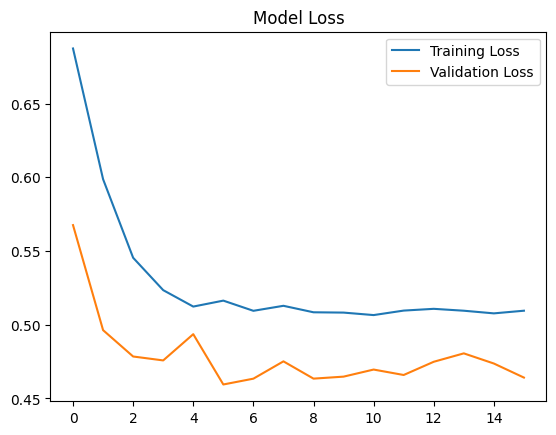

In [18]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [19]:
forecast = []
current_sequence = data_scaled[-sequence_length:].copy()  # Ambil sequence terakhir dari data

for i in range(365):
    # Prediksi langkah berikutnya
    pred = model.predict(current_sequence[np.newaxis, :, :], verbose=0)
    forecast.append(pred.flatten()[0])

    # Teacher forcing: tambahkan nilai aktual jika tersedia
    if i < len(y_test):
        current_sequence = np.append(current_sequence[1:], y_test[i]).reshape(-1, 1)
    else:
        current_sequence = np.append(current_sequence[1:], pred).reshape(-1, 1)

# Inverse scaling
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


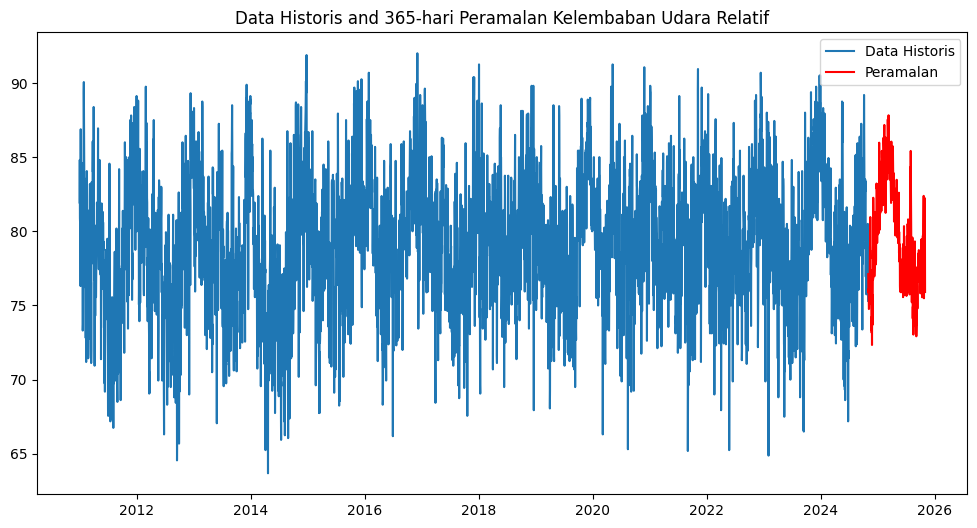

In [42]:
# === Step 6: Visualize Results ===
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=365)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast.flatten()})
forecast_df.set_index('Date', inplace=True)

# Combine historical data and forecast
df_combined = pd.concat([df, forecast_df])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Kelembaban'], label='Data Historis')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Peramalan', color='red')
plt.title('Data Historis and 365-hari Peramalan Kelembaban Udara Relatif')
plt.legend()
plt.show()

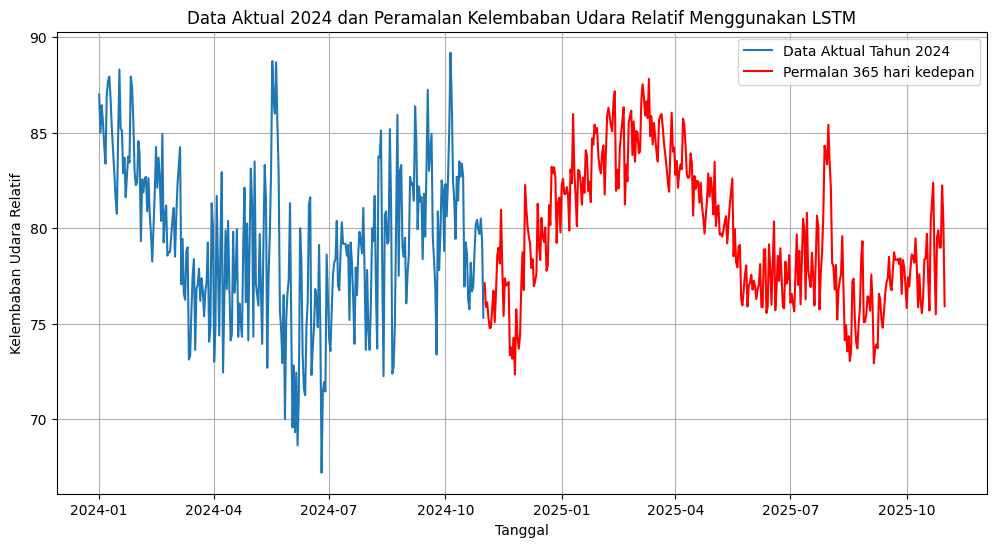

In [43]:
# Pastikan kolom index adalah datetime
df_combined.index = pd.to_datetime(df_combined.index)
forecast_df.index = pd.to_datetime(forecast_df.index)

# Filter data aktual untuk tahun 2024 saja
df_actual_2024 = df_combined.loc['2024']

# Gabungkan data aktual 2024 hingga forecast
df_visualize = pd.concat([df_actual_2024, forecast_df])

# Plot data aktual dan forecast
plt.figure(figsize=(12, 6))
plt.plot(df_actual_2024.index, df_actual_2024['Kelembaban'], label='Data Aktual Tahun 2024')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Permalan 365 hari kedepan', color='red')
plt.title('Data Aktual 2024 dan Peramalan Kelembaban Udara Relatif Menggunakan LSTM')
plt.xlabel('Tanggal')
plt.ylabel('Kelembaban Udara Relatif')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
forecast_df

,Forecast
Date,
2024-11-01,77.114296
2024-11-02,75.879478
2024-11-03,76.111389
2024-11-04,75.338097
2024-11-05,74.761398
...,...
2025-10-27,78.987595
2025-10-28,78.984901
2025-10-29,82.238251


In [45]:
forecast_df.to_csv('D:/cool/TA/data/forecast_results_kelembaban.csv', index=False)

In [64]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length and features
SEQ_LENGTH = 60  # Panjang sequence untuk 1 tahun (harian)
num_features = len(df.columns)  # Jumlah fitur dalam dataset

# Create sequences and corresponding labels
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]  # Ambil window sepanjang seq_length
        label = data[i + seq_length][0]  # Target adalah nilai fitur pertama
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Generate sequences and labels
sequences, labels = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
train_size = int(0.9 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (4493, 60, 1)
Train Y shape: (4493,)
Test X shape: (500, 60, 1)
Test Y shape: (500,)


In [54]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Define sequence length and features
sequence_length = 10  # Number of time steps in each sequence
num_features = len(df.columns)

# Create sequences and corresponding labels
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(scaled_data) - sequence_length):
        seq = scaled_data[i:i+sequence_length]
        label = scaled_data[i+sequence_length][1]  # column index
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 365  # for 24 hours sequence
sequences, labels = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
train_size = int(0.9 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)

Train X shape: (4538, 10, 3)
Train Y shape: (4538,)
Test X shape: (505, 10, 3)
Test Y shape: (505,)


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping]
)

Epoch 1/100
57/57 [==============================] - 12s 119ms/step - loss: 0.0376 - val_loss: 0.0179
Epoch 2/100
57/57 [==============================] - 6s 100ms/step - loss: 0.0221 - val_loss: 0.0184
Epoch 3/100
57/57 [==============================] - 6s 99ms/step - loss: 0.0214 - val_loss: 0.0177
Epoch 4/100
57/57 [==============================] - 6s 99ms/step - loss: 0.0213 - val_loss: 0.0191
Epoch 5/100
57/57 [==============================] - 6s 99ms/step - loss: 0.0206 - val_loss: 0.0171
Epoch 6/100
57/57 [==============================] - 6s 100ms/step - loss: 0.0208 - val_loss: 0.0169
Epoch 7/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0196 - val_loss: 0.0169
Epoch 8/100
57/57 [==============================] - 6s 110ms/step - loss: 0.0199 - val_loss: 0.0164
Epoch 9/100
57/57 [==============================] - 6s 111ms/step - loss: 0.0190 - val_loss: 0.0162
Epoch 10/100
57/57 [==============================] - 6s 111ms/step - loss: 0.0184 - val_loss

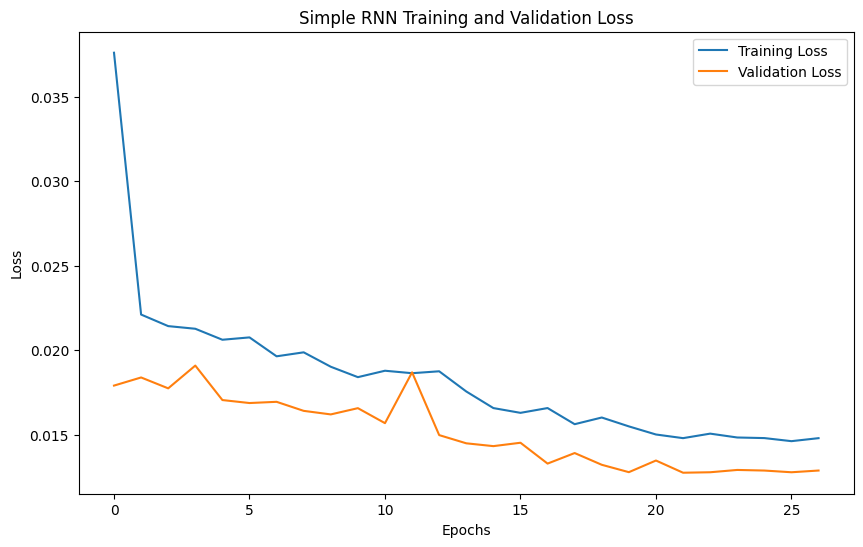

In [67]:
# Simple RNN
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = model.predict(test_x)

# Calculate evaluation metrics 90:10
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

16/16 [==============================] - 2s 27ms/step
Mean Absolute Error (MAE): 0.08344976207811686
Mean Squared Error (MSE): 0.011458713971377108
Root Mean Squared Error (RMSE): 0.10704538276533514


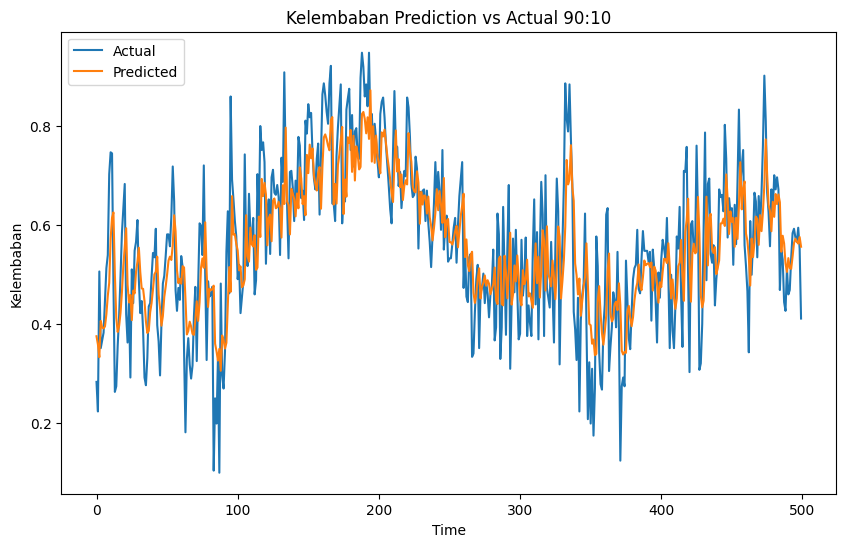

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Kelembaban Prediction vs Actual 90:10')
plt.xlabel('Time')
plt.ylabel('Kelembaban')
plt.legend()
plt.show()

In [70]:
# Forecast 365 hari ke depan
forecast_days = 365
forecast = []

# Ambil input terakhir dari dataset (sequences terakhir yang dipakai)
current_sequence = scaled_data[-SEQ_LENGTH:]  # Ambil sequence terakhir

# Iteratif prediksi hari ke depan
for day in range(forecast_days):
    # Prediksi menggunakan model
    prediction = model.predict(current_sequence.reshape(1, SEQ_LENGTH, num_features), verbose=0)
    
    # Simpan hasil prediksi
    forecast.append(prediction[0][0])
    
    # Update sequence: geser ke depan dan tambahkan prediksi
    next_sequence = np.append(current_sequence[1:], [[prediction[0][0]] * num_features], axis=0)
    current_sequence = next_sequence

# Invers transform untuk mengembalikan ke skala aslinya
forecast = scaler.inverse_transform([[val] + [0] * (num_features - 1) for val in forecast])

# Buat dataframe untuk hasil forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
forecast_df = pd.DataFrame(forecast[:, 0], index=forecast_index, columns=['Forecast'])

# Tampilkan hasil prediksi
print(forecast_df)

             Forecast
2024-11-01  77.627481
2024-11-02  78.184468
2024-11-03  78.434239
2024-11-04  78.590584
2024-11-05  78.686318
...               ...
2025-10-27  78.708578
2025-10-28  78.708578
2025-10-29  78.708578
2025-10-30  78.708578
2025-10-31  78.708578

[365 rows x 1 columns]


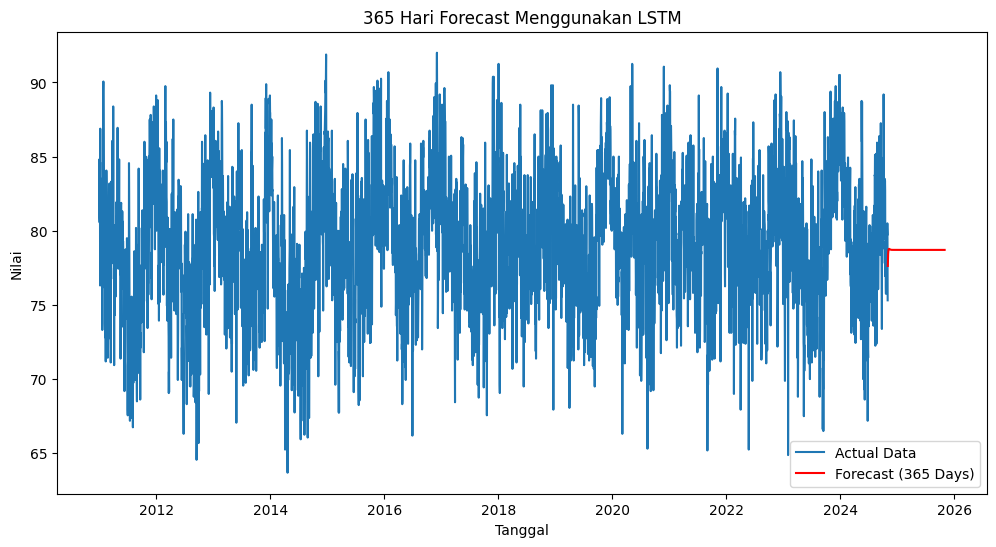

In [72]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.iloc[:, 0], label="Actual Data")
plt.plot(forecast_df.index, forecast_df['Forecast'], label="Forecast (365 Days)", color='red')
plt.title("365 Hari Forecast Menggunakan LSTM")
plt.xlabel("Tanggal")
plt.ylabel("Nilai")
plt.legend()
plt.show()

In [27]:
from datetime import timedelta
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [ ]:
future = 365
forcast = []
Xin = test_x[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 62ms/step
[0.55739516]
1/1 [==============================] - 0s 75ms/step
[0.55739516, 0.5573951]
1/1 [==============================] - 0s 75ms/step
[0.55739516, 0.5573951, 0.5573951]
1/1 [==============================] - 0s 73ms/step
[0.55739516, 0.5573951, 0.5573951, 0.5573951]
1/1 [==============================] - 0s 73ms/step
[0.55739516, 0.5573951, 0.5573951, 0.5573951, 0.5573951]
1/1 [==============================] - 0s 83ms/step
[0.55739516, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.5573951]
1/1 [==============================] - 0s 94ms/step
[0.55739516, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.5573951]
1/1 [==============================] - 0s 80ms/step
[0.55739516, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.55739516]
1/1 [==============================] - 0s 79ms/step
[0.55739516, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.5573951, 0.55739516, 0.55739516]
1/1 [===========

In [ ]:
time

In [ ]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [ ]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [ ]:
df_result